In [1]:
# Why is this not just a standard feature of every notebook?
%load_ext autoreload
%autoreload 2

In [2]:
from kpl_layers import polynomial
import torch
import matplotlib.pyplot as plt
import math

In [3]:
psnn = polynomial.PolySplineLayer(1,3,10,1)
print(psnn)

PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=3, out_features=10, bias=True)
  )
  (attention): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=10, bias=True)
      (3): Softmax(dim=-1)
    )
  )
)


In [4]:
print(psnn.state_dict())

OrderedDict([('poly_coeffs.0.weight', tensor([[-0.4371,  0.1531,  0.5370],
        [-0.3764, -0.2992, -0.1392],
        [-0.3683, -0.0354,  0.2033],
        [-0.1487, -0.2957,  0.5180],
        [-0.3790,  0.2864,  0.0288],
        [-0.3689, -0.4739,  0.3936],
        [-0.3919,  0.1422, -0.2185],
        [ 0.0256, -0.4851, -0.4073],
        [ 0.2779, -0.1209,  0.5547],
        [-0.0222,  0.4625,  0.5154]])), ('poly_coeffs.0.bias', tensor([ 0.5004,  0.4336, -0.5241,  0.3058, -0.2641,  0.3253, -0.4072,  0.4871,
        -0.1190, -0.0740])), ('attention.0.0.weight', tensor([[-0.5540],
        [-0.3391],
        [ 0.6234],
        [-0.4428],
        [-0.9036],
        [ 0.4153],
        [-0.7295],
        [-0.4924],
        [-0.2206],
        [-0.7549],
        [ 0.2962],
        [-0.3208],
        [ 0.6097],
        [ 0.2311],
        [-0.0672],
        [ 0.6700],
        [ 0.4671],
        [ 0.1156],
        [-0.4502],
        [ 0.3915],
        [ 0.3136],
        [-0.2448],
        [-0.98

In [5]:
n_parameters = 0
for p in psnn.parameters():
    print('{}: {} ({}->{})'.format(p.name,type(p),p.size(),torch.numel(p)))
    n_parameters += torch.numel(p)
print(f'Total parameters: {n_parameters}')

None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10, 3])->30)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10])->10)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([100, 1])->100)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([100])->100)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10, 100])->1000)
None: <class 'torch.nn.parameter.Parameter'> (torch.Size([10])->10)
Total parameters: 1250


In [6]:
# Create some random data to train on
n_train = 100000
x_train = 3*math.tau*torch.rand(n_train,1)
y_train = torch.cos(x_train)
ds_train = torch.utils.data.TensorDataset(x_train,y_train)
loader_train = torch.utils.data.DataLoader(ds_train,batch_size=100)

n_test = 1000
x_test = 3*math.tau*torch.rand(n_test,1)
y_test = torch.cos(x_test)
ds_test = torch.utils.data.TensorDataset(x_test,y_test)
loader_test = torch.utils.data.DataLoader(ds_test,batch_size=100)

In [7]:
# Configure the network for training
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(psnn.parameters(),lr=1e-4)

In [16]:
# Taken from the pytorch tutorial code
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(loader_train, psnn, loss, optimizer)
    test_loop(loader_test, psnn, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 847185.937500  [    0/100000]
loss: 1246.968628  [20000/100000]
loss: 14.718699  [40000/100000]
loss: 1.618594  [60000/100000]
loss: 0.284844  [80000/100000]
Test Error: 
 Avg loss: 0.355564 

Epoch 2
-------------------------------
loss: 0.428046  [    0/100000]
loss: 0.315095  [20000/100000]
loss: 0.341760  [40000/100000]
loss: 0.401977  [60000/100000]
loss: 0.345856  [80000/100000]
Test Error: 
 Avg loss: 0.344954 

Epoch 3
-------------------------------
loss: 0.418439  [    0/100000]
loss: 0.283141  [20000/100000]
loss: 0.278509  [40000/100000]
loss: 0.335348  [60000/100000]
loss: 0.266746  [80000/100000]
Test Error: 
 Avg loss: 0.257979 

Epoch 4
-------------------------------
loss: 0.307111  [    0/100000]
loss: 0.230416  [20000/100000]
loss: 0.186003  [40000/100000]
loss: 0.201073  [60000/100000]
loss: 0.256880  [80000/100000]
Test Error: 
 Avg loss: 0.186761 

Epoch 5
-------------------------------
loss: 0.216403  [    0/100000]


In [10]:
print(psnn.state_dict())

OrderedDict([('poly_coeffs.0.weight', tensor([[-0.2022,  0.2101,  0.5706],
        [-0.3886, -0.3217, -0.1639],
        [-0.3757, -0.0341,  0.2040],
        [-0.1593, -0.3090,  0.5125],
        [-0.4164,  0.2469, -0.0071],
        [ 0.0061, -0.1411,  0.5694],
        [-0.3921,  0.1505, -0.2070],
        [-0.0146, -0.4886, -0.3943],
        [ 0.2688, -0.1223,  0.5566],
        [ 0.2272,  0.6737,  0.6100]])), ('poly_coeffs.0.bias', tensor([ 1.0099,  0.4333, -0.5415,  0.3157, -0.2955,  0.5688, -0.4428,  0.3788,
        -0.1289,  0.0686])), ('attention.0.0.weight', tensor([[-0.5540],
        [-0.3391],
        [ 0.6365],
        [-0.4428],
        [-1.1948],
        [ 0.4035],
        [-1.5393],
        [-0.1002],
        [-1.9694],
        [-0.7549],
        [ 0.2929],
        [-0.3208],
        [ 0.6051],
        [ 0.2466],
        [-0.0672],
        [ 0.6737],
        [ 0.4593],
        [ 0.1255],
        [-0.3251],
        [ 0.3970],
        [ 0.3220],
        [-0.2054],
        [-1.26

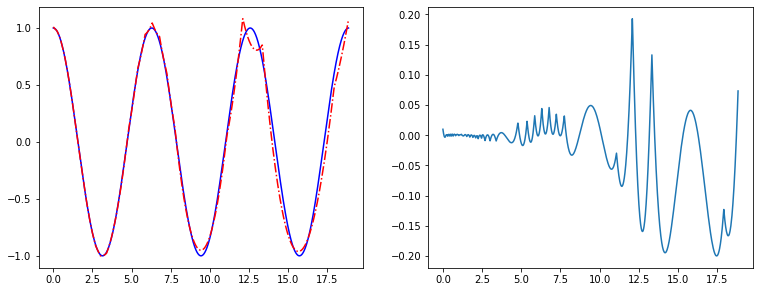

In [11]:
x = torch.arange(0,3*math.tau,0.01)
y_true = torch.cos(x)
with torch.no_grad():
    y_pred = psnn(x[:,None])[:,0]
plt.figure(figsize=(12.8,4.8))
plt.subplot(121)
plt.plot(x,y_true,'b',x,y_pred,'r-.')
plt.subplot(122)
plt.plot(x,y_pred-y_true)

In [12]:
with torch.no_grad():
    attn = psnn.attention[0](x[:,None])
    poly = psnn.poly_coeffs[0](psnn.monomial_layer(x[:,None]))

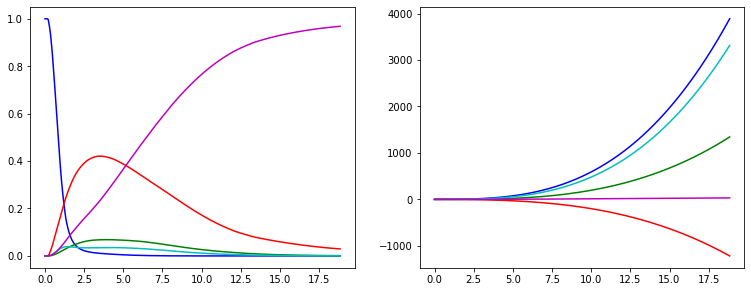

In [13]:
plt.figure(figsize=(12.8,4.8))
plt.subplot(121)
plt.plot(x,attn[:,0],'b',x,attn[:,1],'r',x,attn[:,2],'g',x,attn[:,3],'c',x,attn[:,4],'m')
plt.subplot(122)
plt.plot(x,poly[:,0],'b',x,poly[:,1],'r',x,poly[:,2],'g',x,poly[:,3],'c',x,poly[:,4],'m');

In [14]:
y_true.shape

torch.Size([1885])